In [1]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [2]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [3]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [4]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [5]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [17]:
# Combine all 4 datasets
data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,Don't you mean Brooklyn?,0.0
1,:(,0.0
2,"Forcing gender inequality, obviously.",1.0
3,But it sure would make a sweet crossover,0.0
4,"As I've said before, from the way SJWs talk ab...",0.0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042641 entries, 0 to 1042640
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   text    1042588 non-null  object 
 1   label   1042641 non-null  float64
dtypes: float64(1), object(1)
memory usage: 15.9+ MB


In [19]:
##create arrays to store the headlines and labels
text = list(data['text'])
labels = list(data['label'])
#text_dataset = tf.data.Dataset.from_tensor_slices(text)

In [20]:
##define the parameters for tokenizing and padding
vocab_size = 10000
embedding_dim = 32
max_length = 120
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"
training_size = 200000

In [21]:
##create the text vectorization layer and create the vocab
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize='lower_and_strip_punctuation', split='whitespace', output_mode='int', output_sequence_length=max_length)

vectorize_layer.adapt(text)

In [22]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 120)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                        

In [23]:
##training set from 0 to training size
training_sentences = text[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = text[training_size:]
testing_labels = labels[training_size:]

In [24]:
num_epochs = 10
history = model.fit(
    training_sentences, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(testing_sentences, testing_labels)
    )

Epoch 1/10
6250/6250 [==============================] - 3538s 565ms/step - loss: 0.5868 - accuracy: 0.6856 - val_loss: 0.5669 - val_accuracy: 0.7039
Epoch 2/10
6250/6250 [==============================] - 3805s 609ms/step - loss: 0.5422 - accuracy: 0.7230 - val_loss: 0.5654 - val_accuracy: 0.7034
Epoch 3/10
6250/6250 [==============================] - 5191s 831ms/step - loss: 0.5145 - accuracy: 0.7432 - val_loss: 0.5716 - val_accuracy: 0.7015
Epoch 4/10
6250/6250 [==============================] - 7159s 1s/step - loss: 0.4887 - accuracy: 0.7602 - val_loss: 0.5832 - val_accuracy: 0.7015
Epoch 5/10
6250/6250 [==============================] - 8347s 1s/step - loss: 0.4595 - accuracy: 0.7784 - val_loss: 0.6058 - val_accuracy: 0.6923
Epoch 6/10
6250/6250 [==============================] - 9057s 1s/step - loss: 0.4271 - accuracy: 0.7976 - val_loss: 0.6742 - val_accuracy: 0.6929
Epoch 7/10
6250/6250 [==============================] - 9680s 2s/step - loss: 0.3935 - accuracy: 0.8150 - val_loss:

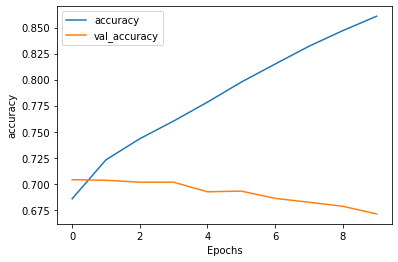

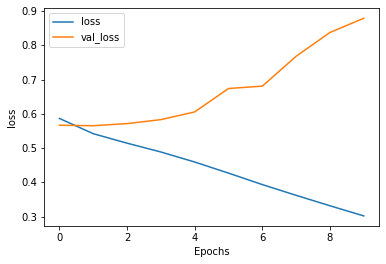

In [25]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [26]:
sentences = ["Now we know why some animals eat their own children.", "game of thrones season finale showing this sunday night","Please, keep talking. I always yawn when I am interested."]
print(model.predict(sentences))

1/1 [==============================] - 1s 1s/step
[[8.5455990e-01]
 [3.7218185e-04]
 [2.2272461e-03]]


In [27]:
model.save('./model_saves')

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets
